#Labradoodle or Fried Chicken?

##Overview
This was made with transfer learning built using the MobileNet architecture, and achieved 97% accuracy. I chose this topic after learning about the [chihuaua-muffin](https://medium.freecodecamp.org/chihuahua-or-muffin-my-search-for-the-best-computer-vision-api-cbda4d6b425d) meme, and thought it would be a great ML exercise. There wasn't a readily available chihuaua-muffin dataset, so I chose a topic with a readily available [dataset](https://github.com/TZstatsADS/Fall2016-proj3-grp9)



In [0]:
# import standard libraries
!pip install -U -q PyDrive

import tensorflow as tf
import numpy as np
import zipfile
import sys, os, shutil, zipfile

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd

# import matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os

tf.enable_eager_execution()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation

cwd = os.getcwd()
print('cwd:',cwd)
os.listdir(cwd)


    100% |████████████████████████████████| 993kB 19.3MB/s 
cwd: /content


['.config', 'sample_data']

In [0]:
#Clear file structure
os.listdir(cwd)

# # Get directory name
mydir= 'dog-or-chicken'

## Try to remove tree; if failed show an error using try...except on screen
try:
    shutil.rmtree(mydir)
except OSError as e:
    print ("Error: %s - %s." % (e.filename, e.strerror))
print('----')
os.listdir(cwd)

try:
    os.remove("/content/dog-or-chicken.zip")
except FileNotFoundError:
    print ("File Not Found")

print('finished')
os.listdir(cwd)

Error: dog-or-chicken - No such file or directory.
----
File Not Found
finished


['.config', 'sample_data']

In [0]:
# Unzip our hotdog images.
# zip_ref = zipfile.ZipFile('hot-dog-not-hot-dog.zip', 'r')
# zip_ref.extractall('./hotdog_data')
# zip_ref.close()


#YOUR FILE ID ( GET IT WITH THE SHARING URL: https://drive.google.com/open?id=19ubN7KAbz0OJTKB4lTU3Hu3tJkx9QkWm )
zip_id = '1A6Fp_JzU7voX0lx7xSbyHRH4ci4PYvYR'

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [0]:
print('cwd: ',os.listdir(cwd))

if os.path.exists('dog-or-chicken'):
  print('dog-or-chicken exists!')

if not os.path.exists('dog-or-chicken'):
    os.makedirs('dog-or-chicken')
    print('made directory')

# DOWNLOAD ZIP
print ("Downloading zip file")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('dog-or-chicken.zip')

# UNZIP ZIP
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('dog-or-chicken.zip', 'r')
zip_ref.extractall('./dog_data')
zip_ref.close()

print('finished\n')

print(os.listdir(cwd))
print(os.listdir('/content/dog_data'))
print(os.listdir('/content/dog_data/dog-or-chicken'))

['.config', 'adc.json', 'sample_data']
------
made directory
Uncompressing zip file
finished


In [0]:
# Set up datagenerators that can read images from our dataset into Keras.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/dog_data/dog-or-chicken/train',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/content/dog_data/dog-or-chicken/test',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')

Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
# Lets take a look at some of the samples.
class_names = ['Chicken', 'Dog']
test_data, test_labels = validation_generator.next()

for i, sample in enumerate(test_data):
  label = test_labels[i]
  plt.imshow(sample)
  print(class_names[int(label)])
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# Create and load the weights for a model, we'll use MobileNet a state of the art fast architecture.
feature_layers = tf.keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=[224, 224, 3])
# Setting include_top=False makes it so we dont have any output layers, we'll add those ourself!
feature_layers.summary()

Instructions for updating:
Colocations handled automatically by placer.
17227776/17225924 [==============================] - 0s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_____

In [0]:
# Now lets add our new output layers.
x = feature_layers.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

In [0]:
# Combine feature layers with our new output layers.
model = tf.keras.Model(inputs=feature_layers.input, outputs=preds)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [0]:
# Now specify that only the last 4 layers should be trained.
for layer in model.layers[:-4]:
  layer.trainable = False
for layer in model.layers[-4:]:
  layer.trainable = True

In [0]:
# Now we're all set up and ready to train! We need only set an optimizer and fit like usual.
model.compile(optimizer=tf.train.GradientDescentOptimizer(0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(generator=train_generator, validation_data=validation_generator, epochs=5)#,steps_per_epoch=30)


Epoch 1/5
32/32 [==============================] - 34s 1s/step - loss: 0.3512 - acc: 0.8620 - val_loss: 0.1758 - val_acc: 0.9490
Epoch 2/5
32/32 [==============================] - 26s 820ms/step - loss: 0.1272 - acc: 0.9700 - val_loss: 0.0714 - val_acc: 0.9840
Epoch 3/5
32/32 [==============================] - 26s 804ms/step - loss: 0.1069 - acc: 0.9680 - val_loss: 0.1188 - val_acc: 0.9540
Epoch 4/5
32/32 [==============================] - 26s 800ms/step - loss: 0.0511 - acc: 0.9870 - val_loss: 0.1041 - val_acc: 0.9600
Epoch 5/5
32/32 [==============================] - 26s 811ms/step - loss: 0.0512 - acc: 0.9850 - val_loss: 0.1023 - val_acc: 0.9590


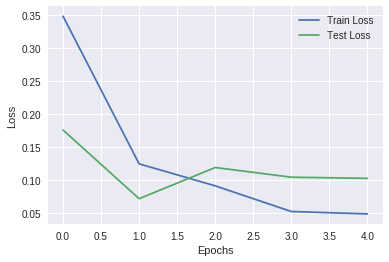

In [0]:
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [0]:
from skimage.color import rgba2rgb
import skimage.io as io
def classify_dog_chicken(model, url):
  # Load the image from the passed url.
  image = io.imread(url)
  #print('shape:',image.shape)
  if image.shape[2] == 4:
    image = rgba2rgb(image)
  
  # Display the image.
  plt.imshow(image)
  plt.show()
  
  # Preprocess image a little for our network.
  image = image/255.0
  image = image[tf.newaxis, ...]
  image = tf.image.resize_images(image, [224, 224])
  #print('shape:',image.shape)
  
  # Get our guess.
  probs = model.predict(image,steps=1)
  print("Probabilities: ", probs)
  preds = tf.argmax(probs, axis=-1).numpy()
  #print(np.array(preds))
  #print('preds:',preds)
  #print('length:',len(preds))
  print(class_names[int(np.average(preds))])
   

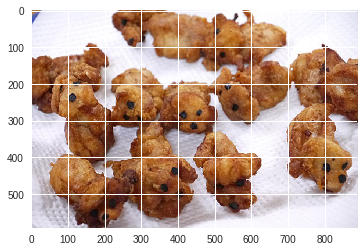

Probabilities:  [[0.9969078  0.00309218]]
Chicken


In [0]:
classify_dog_chicken(model, "https://5f7mk98d5d69eqvo-zippykid.netdna-ssl.com/wp-content/uploads/2016/05/P1010698.jpg")

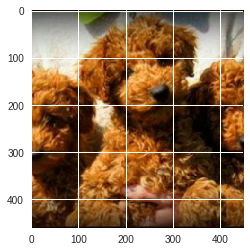

Probabilities:  [[0.60600656 0.39399347]]
Chicken


In [0]:
classify_dog_chicken(model, 'https://cdn.playbuzz.com/cdn//8909cb37-94dd-4414-849c-1d0406bd9c7b/6f155460-10b1-4bcb-8ef2-f08505d2fb92.jpg')

#tricked it!

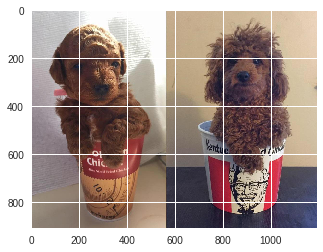

Probabilities:  [[0.02835282 0.97164714]]
Dog


In [0]:
classify_dog_chicken(model, "https://i.redd.it/io4m41pcipgz.jpg")

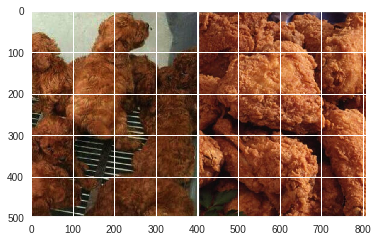

Probabilities:  [[0.598701   0.40129897]]
Chicken


In [0]:
classify_dog_chicken(model, "https://i.barkpost.com/wp-content/uploads/2016/03/labrachick.jpg?q=70&fit=crop&crop=entropy&w=808&h=500")

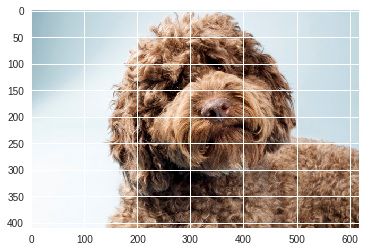

Probabilities:  [[0.05482984 0.9451701 ]]
Dog


In [0]:
classify_dog_chicken(model, "https://thenypost.files.wordpress.com/2018/09/85327728.jpg?quality=90&strip=all&w=618&h=410&crop=1")